In [10]:
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
import numpy as np 
from glob import glob 
import random 
import os

from PIL import Image

import cv2 as cv

In [25]:
RES = 256
N_CLASS = 10
BATCH_SIZE = 64
N_TRAIN = 20000

# 26179 images 
N_VAL = 6179 

class_name = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

In [3]:
data_dir = './20220303/archive' 

In [15]:
paths = '.'
images_path = os.path.join(paths, '20220303', 'archive', 'raw-img')

images = glob(images_path + '/*/*')

In [17]:
# images
ttt = Image.open('.\\20220303\\archive\\raw-img\\cane\\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg')
ttt = np.array(ttt)
ttt.shape

(225, 300, 3)

In [26]:
# https://www.kaggle.com/code/min4tozaki/animal-classification
# Converting to center

def centering_img(img, tile_size):
    # size = [RES, RES]
    # size = RE
    
    img_size = img.shape
    
    row = (RES - img_size[0]) // 2
    col = (RES - img_size[1]) // 2
    
    resized_img = img[row : (img_size[0] + row), col : (img_size[1] + col)]
    # return resized_img.resize((tile_size, tile_size))
    return resized_img
    # return img
    
    # resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    # resized[row:(row + img.size[0]), col:(col + img.size[1])] = img

def get_image(img):
    img = Image.open(img).convert('RGB')
    # img = img.resize((RES, RES))
    img = np.array(img)
    
    print(img.shape)
    
    if img.shape[0] > img.shape[1]:
        tile_size = (int(img.shape[1] * RES / img.shape[0]), RES)
    else:
        tile_size = (int(img.shape[0] * RES / img.shape[1]), RES)
        
    print(tile_size)
    
    img = centering_img(img, tile_size)
    
    
    print(img.shape)
    # img = np.array(img) / 254.
    return img 


def get_label(name):
    lbl = name.split('\\')[-2]
    # print(lbl)
    return to_categorical(class_name.index(lbl), N_CLASS)


# for file_path in images:
images_list = np.zeros((len(images), RES, RES, 3))
labels_list = np.zeros((len(images), N_CLASS))

for idx, val in enumerate(images):
    images_list[idx, :, :, :] = get_image(val)
    labels_list[idx, :] = get_label(val)
    
    
images_list.shape, labels_list.shape

MemoryError: Unable to allocate 38.3 GiB for an array with shape (26179, 256, 256, 3) and data type float64

In [32]:
# labels_list
# images_list

array([[[[0.90588235, 0.90588235, 0.86666667],
         [0.89411765, 0.89411765, 0.85490196],
         [0.88627451, 0.88627451, 0.84705882],
         ...,
         [0.93333333, 0.90588235, 0.88235294],
         [0.9372549 , 0.90980392, 0.88627451],
         [0.94117647, 0.91372549, 0.89019608]],

        [[0.89803922, 0.89803922, 0.85882353],
         [0.88627451, 0.88627451, 0.84705882],
         [0.87843137, 0.87843137, 0.83921569],
         ...,
         [0.92941176, 0.90196078, 0.87843137],
         [0.93333333, 0.90588235, 0.88235294],
         [0.9372549 , 0.90980392, 0.88627451]],

        [[0.89019608, 0.89019608, 0.85098039],
         [0.88235294, 0.88235294, 0.84313725],
         [0.87058824, 0.87058824, 0.83137255],
         ...,
         [0.92156863, 0.89411765, 0.87058824],
         [0.9254902 , 0.89803922, 0.8745098 ],
         [0.92941176, 0.90196078, 0.87843137]],

        ...,

        [[0.3372549 , 0.34509804, 0.34117647],
         [0.32941176, 0.3372549 , 0.33333333]

In [36]:
list_ds = tf.data.Dataset.from_tensor_slices((images_list, labels_list))

val_size = int(len(images) * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [19]:
for img, lbl in list_ds.take(1):
    pass 


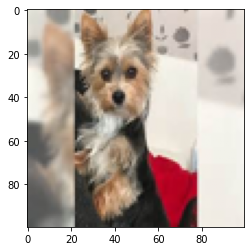

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float64)


In [20]:

plt.imshow(img)
# plt.title(lbl)
plt.show()
print(lbl)

In [37]:
train_ds1 = train_ds.shuffle(100).batch(64)
val_ds1 = val_ds.batch(64)

In [6]:
# image = [] 
# label = []
# for img in images: 
#     img = 
#     label = img.split('\\')[-2]

images_ds = tf.keras.preprocessing.image_dataset_from_directory(
    images_path, 
    # validation_split=0.2,
    shuffle=True, 
    image_size=(RES, RES), 
    batch_size=BATCH_SIZE,
    label_mode = 'categorical'
)



Found 26179 files belonging to 10 classes.


In [7]:
def preprocessing(image, label):
    image = tf.cast(image / 255. , tf.float32)
    return image, label

In [8]:
images_ds.unbatch().map(preprocessing).batch(BATCH_SIZE)

<BatchDataset shapes: ((None, 100, 100, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
train_size = int(0.7 * len(images_ds))

train_ds = images_ds.take(train_size)
val_ds = images_ds.skip(train_size)

In [11]:
# images_ds.prefetch(tf.data.AUTOTUNE)
# len(images_ds)
train_ds.prefetch(tf.data.AUTOTUNE)
val_ds.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 100, 100, 3), (None, 10)), types: (tf.float32, tf.float32)>

C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


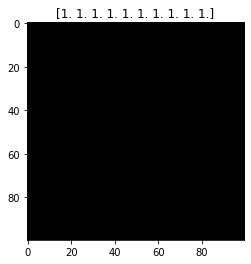

In [36]:
for img, label in train_ds1.take(5):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(label[0].numpy()) 
    
plt.show()

In [38]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [41]:
def create_model():
    inputs = tf.keras.Input(shape=(RES, RES, 3))
    x = preprocess_input(inputs) 
    x = mobilenetv3(x) 
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dense(N_CLASS)(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

In [42]:
model = create_model()

In [44]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])


In [45]:
hist = model.fit(train_ds1, epochs=10, validation_data=val_ds1)

Epoch 1/10
328/328 [==============================] - 184s 543ms/step - loss: 2.3329 - accuracy: 0.0934 - val_loss: 2.6103 - val_accuracy: 0.0000e+00
Epoch 2/10
328/328 [==============================] - 174s 531ms/step - loss: 2.2699 - accuracy: 0.1889 - val_loss: 2.7166 - val_accuracy: 0.0000e+00
Epoch 3/10
328/328 [==============================] - 162s 494ms/step - loss: 2.2399 - accuracy: 0.2090 - val_loss: 2.9383 - val_accuracy: 0.0000e+00
Epoch 4/10
230/328 [====================>.........] - ETA: 44s - loss: 2.2539 - accuracy: 0.0501

KeyboardInterrupt: 

In [110]:
def aug(image, label): 
    image = tf.image.random_crop(image, [RES, RES, 3])
    image = tf.image.random_flip_left_right(image) 
    return image, label

In [111]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [112]:
model = create_model() 

In [113]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy']
              )

In [114]:
hist = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
287/287 [==============================] - 28s 86ms/step - loss: 0.9747 - accuracy: 0.7277 - val_loss: 1.1479 - val_accuracy: 0.6378
Epoch 2/50
287/287 [==============================] - 24s 84ms/step - loss: 0.6114 - accuracy: 0.8410 - val_loss: 1.2149 - val_accuracy: 0.6231
Epoch 3/50
287/287 [==============================] - 24s 85ms/step - loss: 0.4712 - accuracy: 0.8785 - val_loss: 0.9621 - val_accuracy: 0.7173
Epoch 4/50
287/287 [==============================] - 24s 84ms/step - loss: 0.3890 - accuracy: 0.8961 - val_loss: 0.8918 - val_accuracy: 0.7367
Epoch 5/50
287/287 [==============================] - 24s 84ms/step - loss: 0.3270 - accuracy: 0.9119 - val_loss: 0.9334 - val_accuracy: 0.7286
Epoch 6/50
287/287 [==============================] - 25s 85ms/step - loss: 0.2722 - accuracy: 0.9286 - val_loss: 0.8722 - val_accuracy: 0.7506
Epoch 7/50
287/287 [==============================] - 25s 87ms/step - loss: 0.2397 - accuracy: 0.9368 - val_loss: 0.9599 - val_accuracy:

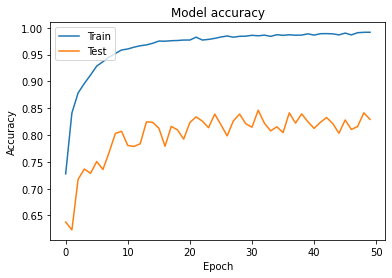

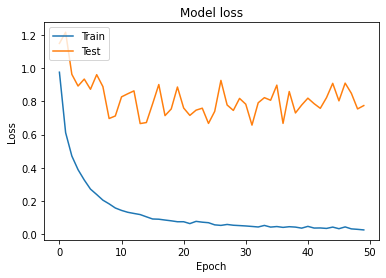

In [115]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()